In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

# Load the Food-11 dataset with transforms without augmentation
train_dataset = torchvision.datasets.ImageFolder(root='./Food-11/training', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./Food-11/validation', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./Food-11/evaluation', transform=transform)

# Dataloaders for the Food-11 dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [4]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in train_loader:
    print(image.shape[1])
    break

3


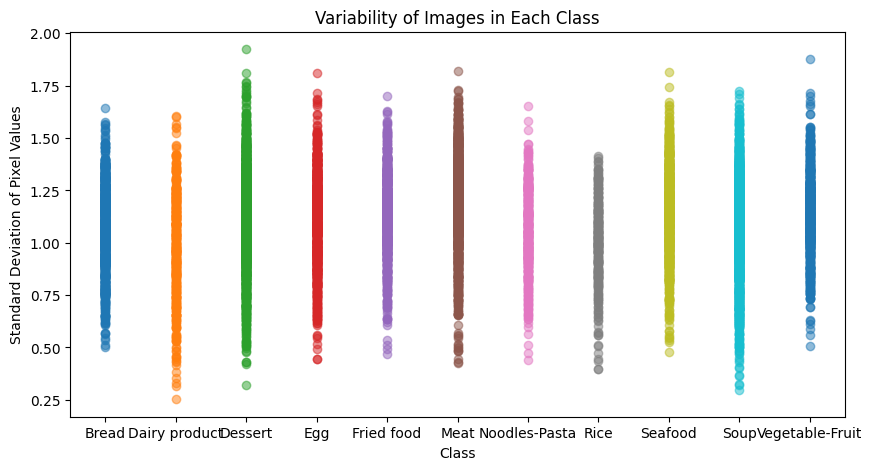

In [9]:
def plot_class_sample_variance(train_loader: DataLoader):
    classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
    class_variances = {class_name: [] for class_name in classes}

    # Iterate through each image
    for images, labels in train_loader:                                     
        for i, label in enumerate(labels):
            # Calculate and append the standard deviation of the pixel value
            class_variances[classes[label]].append(images[i].std().item())

    fig, ax = plt.subplots(figsize=(10, 5))
    for class_name, variances in class_variances.items():
        ax.scatter([class_name for _ in variances], variances, alpha=0.5)

    ax.set_title('Variability of Images in Each Class')
    ax.set_xlabel('Class')
    ax.set_ylabel('Standard Deviation of Pixel Values')

    plt.show()

plot_class_sample_variance(train_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


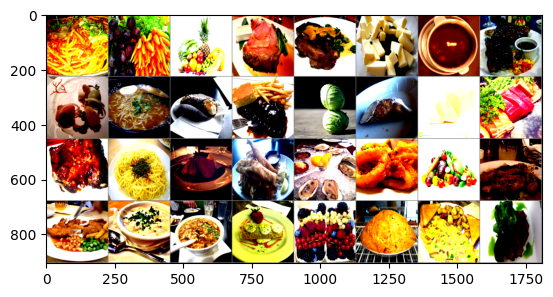

Noodles-Pasta   Vegetable-Fruit Vegetable-Fruit Meat            Meat            Dairy product   Soup            Meat            Dessert         Noodles-Pasta   Dessert         Meat            Vegetable-Fruit Dessert         Dairy product   Seafood         Meat            Noodles-Pasta   Meat            Fried food      Seafood         Fried food      Vegetable-Fruit Meat            Meat            Soup            Soup            Dessert         Vegetable-Fruit Dessert         Egg             Meat           


In [10]:
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:15s}' for j in range(batch_size)))


In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [15]:
def modelTraining(model, criterion, optimizer, earlyStopping=False):
        
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 10
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        training_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.flatten()
            loss_training = criterion(outputs, labels)
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item()

            if i % 300 == 299:
                validation_loss = 0.0
                with torch.no_grad():
                    for data in val_loader:
                        images, labels = data
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_validation = criterion(outputs, labels)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for data in test_loader:
                        images, labels = data
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_testing = criterion(outputs, labels)
                        testing_loss += loss_testing.item()

                training_loss = round((training_loss / 300), 3)
                validation_loss = round((validation_loss / len(val_loader)), 3)
                testing_loss = round((testing_loss / len(test_loader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                training_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 5:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [16]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [17]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC


def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=len(classes))
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

In [ ]:
# Define the list of models to use
model_names = ['resnet18', 'vgg16', 'densenet121']

# Loop over each pre-trained model
for model_name in model_names:
    print("Using model:", model_name)
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        num_classes=len(classes)
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        num_classes=len(classes)
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        num_classes=len(classes)
        model.classifier = nn.Linear(num_ftrs, num_classes)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=model, criterion=criterion,
                                                                                        optimizer=optimizer, earlyStopping=False)
    LossesPlot(training_loss_plt_arr,
            validation_loss_plt_arr, testing_loss_plt_arr)
    perfEvaluation(model=model)

### Model with Regularization

[1, 300], Training loss: 0.808, Validation loss: 0.583, Testing loss: 0.598
[1, 600], Training loss: 0.536, Validation loss: 0.474, Testing loss: 0.491
[2, 300], Training loss: 0.409, Validation loss: 0.491, Testing loss: 0.499
[2, 600], Training loss: 0.382, Validation loss: 0.375, Testing loss: 0.386
[3, 300], Training loss: 0.335, Validation loss: 0.307, Testing loss: 0.316
[3, 600], Training loss: 0.309, Validation loss: 0.288, Testing loss: 0.306
[4, 300], Training loss: 0.275, Validation loss: 0.319, Testing loss: 0.329
[4, 600], Training loss: 0.271, Validation loss: 0.271, Testing loss: 0.284
[5, 300], Training loss: 0.253, Validation loss: 0.28, Testing loss: 0.295
[5, 600], Training loss: 0.239, Validation loss: 0.295, Testing loss: 0.31
[6, 300], Training loss: 0.225, Validation loss: 0.239, Testing loss: 0.264
[6, 600], Training loss: 0.222, Validation loss: 0.23, Testing loss: 0.242
[7, 300], Training loss: 0.203, Validation loss: 0.216, Testing loss: 0.241
[7, 600], Train

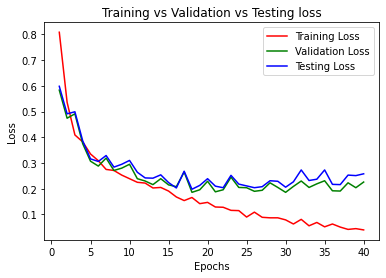

Accuracy on the testing dataset = 93.83
Precision = 0.94
Recall = 0.94
Fscore = 0.94


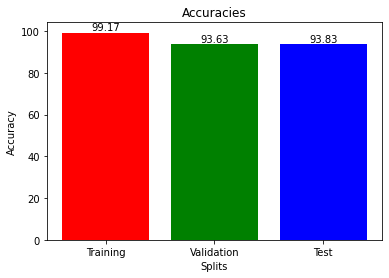

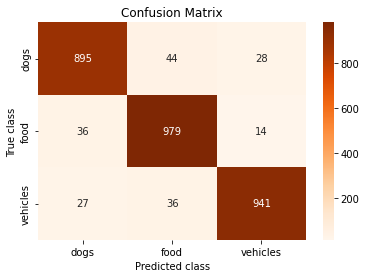

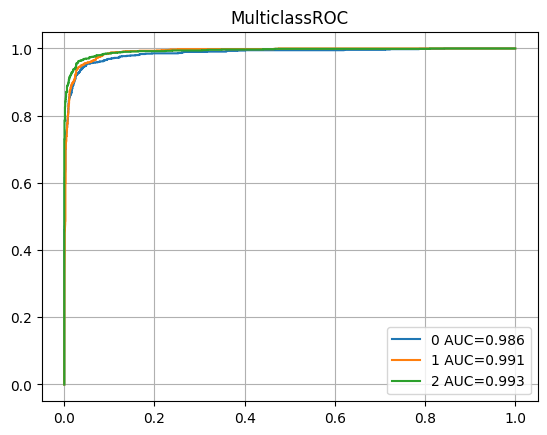

In [13]:
VGG13_M1 = VGG13(dropoutAdd=False).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M1 = nn.CrossEntropyLoss()
optimizer_M1 = optim.Adam(VGG13_M1.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M1, imageAug=False)

### Model with Regularization and Dropout

[1, 300], Training loss: 0.838, Validation loss: 0.675, Testing loss: 0.691
[1, 600], Training loss: 0.547, Validation loss: 0.473, Testing loss: 0.482
[2, 300], Training loss: 0.425, Validation loss: 0.414, Testing loss: 0.421
[2, 600], Training loss: 0.38, Validation loss: 0.413, Testing loss: 0.426
[3, 300], Training loss: 0.348, Validation loss: 0.329, Testing loss: 0.346
[3, 600], Training loss: 0.323, Validation loss: 0.364, Testing loss: 0.373
[4, 300], Training loss: 0.304, Validation loss: 0.274, Testing loss: 0.291
[4, 600], Training loss: 0.285, Validation loss: 0.283, Testing loss: 0.297
[5, 300], Training loss: 0.26, Validation loss: 0.272, Testing loss: 0.282
[5, 600], Training loss: 0.253, Validation loss: 0.271, Testing loss: 0.284
[6, 300], Training loss: 0.239, Validation loss: 0.255, Testing loss: 0.281
[6, 600], Training loss: 0.242, Validation loss: 0.257, Testing loss: 0.262
[7, 300], Training loss: 0.221, Validation loss: 0.242, Testing loss: 0.259
[7, 600], Trai

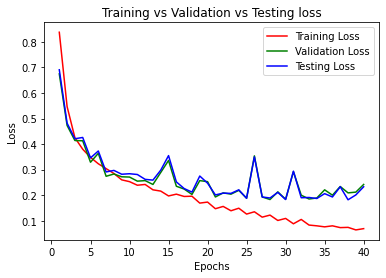

Accuracy on the testing dataset = 94.67
Precision = 0.95
Recall = 0.95
Fscore = 0.95


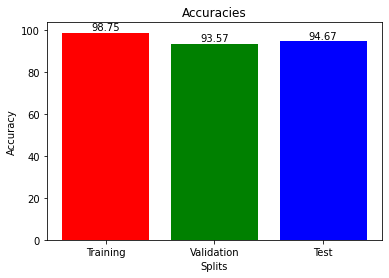

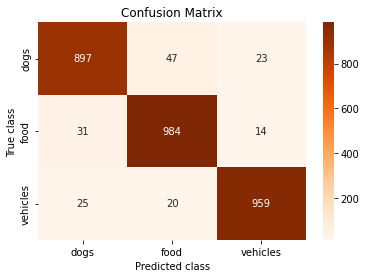

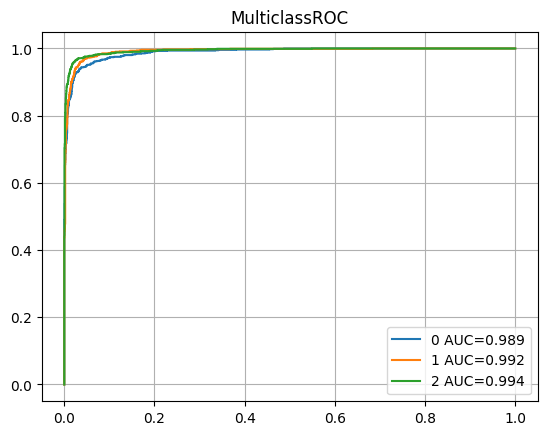

In [14]:
VGG13_M2 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(VGG13_M2.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M2, imageAug=False)

### Model with Regularization, Dropout and Early Stopping

[1, 300], Training loss: 0.864, Validation loss: 0.728, Testing loss: 0.704
[1, 600], Training loss: 0.59, Validation loss: 0.482, Testing loss: 0.501
[2, 300], Training loss: 0.435, Validation loss: 0.466, Testing loss: 0.473
[2, 600], Training loss: 0.393, Validation loss: 0.358, Testing loss: 0.372
[3, 300], Training loss: 0.362, Validation loss: 0.408, Testing loss: 0.425
[3, 600], Training loss: 0.332, Validation loss: 0.378, Testing loss: 0.393
[4, 300], Training loss: 0.314, Validation loss: 0.283, Testing loss: 0.301
[4, 600], Training loss: 0.282, Validation loss: 0.318, Testing loss: 0.332
[5, 300], Training loss: 0.273, Validation loss: 0.26, Testing loss: 0.268
[5, 600], Training loss: 0.254, Validation loss: 0.306, Testing loss: 0.312
[6, 300], Training loss: 0.247, Validation loss: 0.321, Testing loss: 0.314
[6, 600], Training loss: 0.227, Validation loss: 0.266, Testing loss: 0.265
[7, 300], Training loss: 0.221, Validation loss: 0.23, Testing loss: 0.239
[7, 600], Train

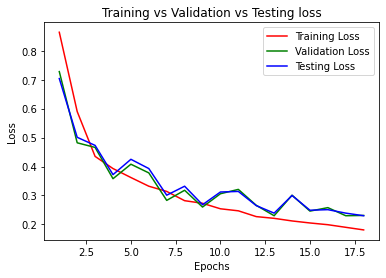

Accuracy on the testing dataset = 92.13
Precision = 0.92
Recall = 0.92
Fscore = 0.92


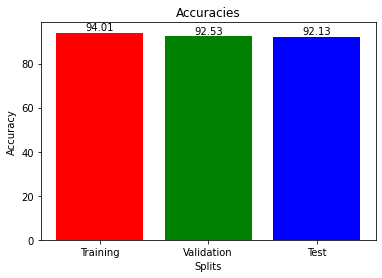

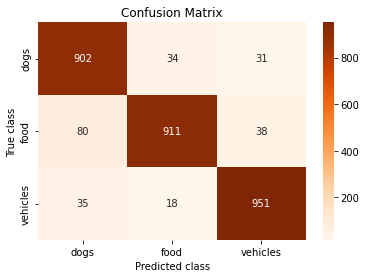

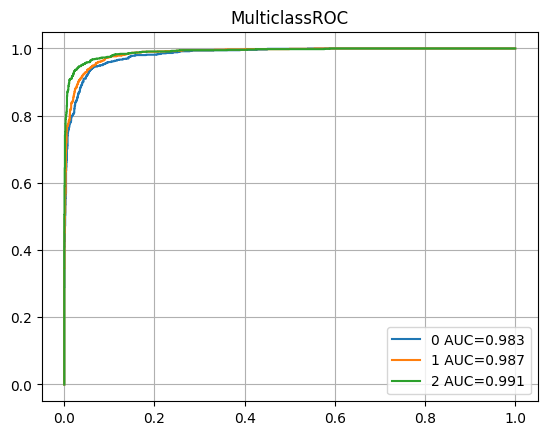

In [15]:
VGG13_M3 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(VGG13_M3.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=True, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M3, imageAug=False)

### Model with Regularization, Dropout, Early Stopping and Image Augmentation

[1, 300], Training loss: 0.913, Validation loss: 0.858, Testing loss: 0.865
[1, 600], Training loss: 0.759, Validation loss: 0.765, Testing loss: 0.782
[2, 300], Training loss: 0.645, Validation loss: 0.63, Testing loss: 0.629
[2, 600], Training loss: 0.606, Validation loss: 0.593, Testing loss: 0.589
[3, 300], Training loss: 0.568, Validation loss: 0.535, Testing loss: 0.532
[3, 600], Training loss: 0.561, Validation loss: 0.574, Testing loss: 0.627
[4, 300], Training loss: 0.536, Validation loss: 0.509, Testing loss: 0.517
[4, 600], Training loss: 0.527, Validation loss: 0.546, Testing loss: 0.555
[5, 300], Training loss: 0.517, Validation loss: 0.495, Testing loss: 0.549
[5, 600], Training loss: 0.498, Validation loss: 0.472, Testing loss: 0.486
[6, 300], Training loss: 0.493, Validation loss: 0.486, Testing loss: 0.49
[6, 600], Training loss: 0.469, Validation loss: 0.473, Testing loss: 0.496
[7, 300], Training loss: 0.467, Validation loss: 0.464, Testing loss: 0.51
[7, 600], Train

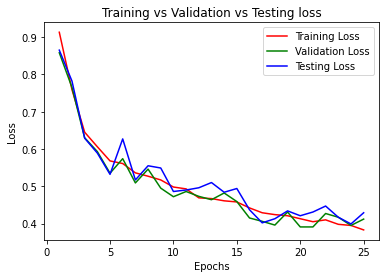

Accuracy on the testing dataset = 82.13
Precision = 0.83
Recall = 0.82
Fscore = 0.82


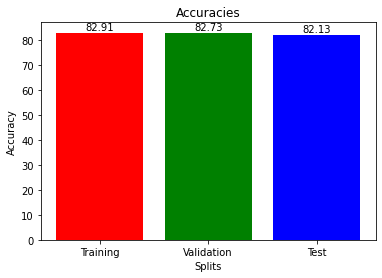

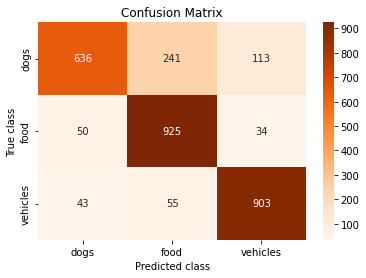

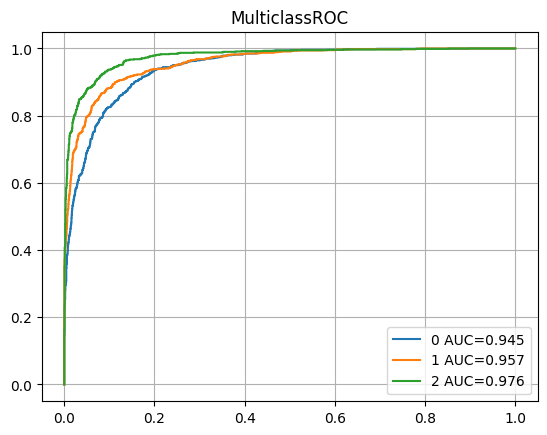

In [19]:
VGG13_M4 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(VGG13_M4.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True, imageAug=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M4, imageAug=True)

### Best model weights

In [21]:
# Save model weights with best accuracy
torch.save(VGG13_M2.state_dict(), 'ngupta22_kchavan_assignment1_part_1.pt')